In [2]:
! pip install -U accelerate
! pip install -U transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 23.6 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.35.2
    Uninstalling transformers-4.35.2:
      Successfully uninstalled transformers-4.35.2


In [3]:
!pip install evaluate rouge_score tensorflow torch


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.0 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.2 MB/s eta 0:00:00
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=9be4aa31504eae85547fb7de19a0400f9b8dcd6bb926098ccc15e4ef348a5658
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [4]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from transformers import pipeline, set_seed
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer #BertTokenizer, BertForSequenceClassification,
from transformers import DataCollatorForSeq2Seq
from transformers import TrainingArguments, Trainer

import torch
import nltk
from nltk.tokenize import sent_tokenize
from datasets import load_metric

from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [5]:
nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [6]:
from huggingface_hub import notebook_login
notebook_login()
#use your huggingface hub token 

In [7]:
topics = pd.read_csv('data/topics.csv')
topics

,id,topic_id,text,type,effectiveness
0,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate
1,de347c859ab6,00944C693682,With so many things in this world that few peo...,Position,Effective
2,c20937683442,00BD97EA4041,"No because, why should a computer know how you...",Position,Adequate
3,9d03e2bef0ff,00C6E82FE5BA,I think that it wouldn't be valueable to have ...,Position,Adequate
4,c2203a58aa5c,013B9AA6B9DB,"Well, some people believe that it was somethin...",Position,Adequate
...,...,...,...,...,...
4019,ad0694ab7bb6,FDF0AEEB14C3,Online classes can help students who are not a...,Position,Adequate
4020,ac820a5b071d,FE3CA06DDCA1,Here are 2 of the reasons I think that the per...,Position,Ineffective
4021,8520e8679735,FEF42864AE28,Technology has given education a new pathway f...,Position,Effective
4022,11a6e326f6e6,FF9E0379CD98,"I think is not benefit for student, that take ...",Position,Adequate


In [8]:
opinions = pd.read_csv('data/opinions.csv', error_bad_lines=False)
opinions

,id,topic_id,text,type,effectiveness
0,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate
1,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,Adequate
2,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,Adequate
3,36a565e45db7,007ACE74B050,"though some say that life on Mars does exist, ...",Rebuttal,Ineffective
4,fb65fe816ba3,007ACE74B050,"It says in paragraph 7, on April 5, 1998, Mars...",Evidence,Adequate
...,...,...,...,...,...
27094,74c58fcc7ef8,FF9E0379CD98,you cant work or cant study after school with ...,Evidence,Adequate
27095,f7bb19f23dcd,FF9E0379CD98,in the end you cant take the class because is ...,Counterclaim,Adequate
27096,9f63b687e76a,FFA381E58FC6,For many people they don't like only asking on...,Claim,Adequate
27097,9d5bd7d86212,FFA381E58FC6,also people have different views and opinions ...,Claim,Adequate


In [9]:
conclusions = pd.read_csv('data/conclusions.csv')
conclusions

,id,topic_id,text,type,effectiveness
0,28a94d3ee425,007ACE74B050,Though people were not satified about how the ...,Concluding Statement,Adequate
1,9fd314f638e5,00944C693682,Individual car use isn't bad. Millions of indi...,Concluding Statement,Effective
2,af494e4e0b4f,00BD97EA4041,To conclusion computers in school shouldn't de...,Concluding Statement,Adequate
3,9c3b9503c9a4,00C6E82FE5BA,The reasons why i said that this would be unva...,Concluding Statement,Adequate
4,b199e5df1815,013B9AA6B9DB,"So, in conclusion, the famous face on Mars was...",Concluding Statement,Adequate
...,...,...,...,...,...
3346,dc9995b62bb6,FDF0AEEB14C3,"In conclusion, many people will argue that onl...",Concluding Statement,Effective
3347,b7c27670f3bc,FE3CA06DDCA1,why you need advice you will talk more then th...,Concluding Statement,Adequate
3348,4d8e878d993a,FEF42864AE28,Technology is a major factor in our world toda...,Concluding Statement,Effective
3349,09692b158697,FF9E0379CD98,Conclusion: you dont are prepared for take the...,Concluding Statement,Ineffective


In [10]:
datas = {
    "conclusions": conclusions,
    "opinions": opinions,
    "topics": topics
}
for name,data in datas.items():
    print('{} \'s non unique id lengt: {}'.format(name,data['id'].shape[0]-data['id'].value_counts().sum()))
    print('\n{} \'s effectiveness value count: \n{}'.format(name,data['effectiveness'].value_counts()))
    print('\n{} \'s type value count: \n{}'.format(name,data.type.value_counts()))
    print('---------------------------------------------------------------')

conclusions 's non unique id lengt: 0

conclusions 's effectiveness value count: 
Adequate       1945
Effective       825
Ineffective     581
Name: effectiveness, dtype: int64

conclusions 's type value count: 
Concluding Statement    3351
Name: type, dtype: int64
---------------------------------------------------------------
opinions 's non unique id lengt: 0

opinions 's effectiveness value count: 
Adequate       15004
Effective       7048
Ineffective     5047
Name: effectiveness, dtype: int64

opinions 's type value count: 
Evidence        12105
Claim           11977
Counterclaim     1773
Rebuttal         1244
Name: type, dtype: int64
---------------------------------------------------------------
topics 's non unique id lengt: 0

topics 's effectiveness value count: 
Adequate       2784
Effective       770
Ineffective     470
Name: effectiveness, dtype: int64

topics 's type value count: 
Position    4024
Name: type, dtype: int64
---------------------------------------------------

In [11]:
topics[topics['topic_id']==topics.topic_id.value_counts().keys()[0]]

,id,topic_id,text,type,effectiveness
1973,9a57f78ae853,2B3DBFA4579D,I believe that we should keep the Electoral co...,Position,Adequate
1974,369cd3296b56,2B3DBFA4579D,So I argue to keep the Electoral College to se...,Position,Adequate


In [12]:
topics[topics['topic_id']==topics.topic_id.value_counts().keys()[0]].text.values

array(['I believe that we should keep the Electoral college for our compromise between the election of the president. ',
       'So I argue to keep the Electoral College to select our presidemt for the U.S. '],
      dtype=object)

In [13]:
opinions[opinions['topic_id']==topics.topic_id.value_counts().keys()[-1]]

,id,topic_id,text,type,effectiveness
27096,9f63b687e76a,FFA381E58FC6,For many people they don't like only asking on...,Claim,Adequate
27097,9d5bd7d86212,FFA381E58FC6,also people have different views and opinions ...,Claim,Adequate
27098,cc184624ca8e,FFA381E58FC6,someone can use everything that many people sa...,Evidence,Ineffective


In [14]:
conclusions.topic_id.value_counts()

C0AC797246EE    2
97A6E516249D    2
3869028BB079    2
897004C788FB    2
1CF9D84E94C1    2
               ..
D5D1E85B3EC4    1
D5D31918A943    1
D5FDDB4DFA82    1
D60320508249    1
FFA381E58FC6    1
Name: topic_id, Length: 3332, dtype: int64

In [15]:
topics[topics['topic_id']=='C0AC797246EE']['effectiveness'],conclusions[conclusions.topic_id == 'C0AC797246EE']['effectiveness']

(3211    Adequate
 Name: effectiveness, dtype: object,
 2644    Ineffective
 2645    Ineffective
 Name: effectiveness, dtype: object)

In [16]:
topics[topics.topic_id == '007ACE74B050']


,id,topic_id,text,type,effectiveness
0,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate


In [17]:
conclusions[conclusions.topic_id == '007ACE74B050']

,id,topic_id,text,type,effectiveness
0,28a94d3ee425,007ACE74B050,Though people were not satified about how the ...,Concluding Statement,Adequate


In [18]:
train_concluions = pd.merge(topics, conclusions[['id','topic_id','text']], on='topic_id')
train_concluions.rename({'text_x':'topic','text_y':'summary'}, axis='columns', inplace = True)
train_concluions

,id_x,topic_id,topic,type,effectiveness,id_y,summary
0,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate,28a94d3ee425,Though people were not satified about how the ...
1,de347c859ab6,00944C693682,With so many things in this world that few peo...,Position,Effective,9fd314f638e5,Individual car use isn't bad. Millions of indi...
2,c20937683442,00BD97EA4041,"No because, why should a computer know how you...",Position,Adequate,af494e4e0b4f,To conclusion computers in school shouldn't de...
3,9d03e2bef0ff,00C6E82FE5BA,I think that it wouldn't be valueable to have ...,Position,Adequate,9c3b9503c9a4,The reasons why i said that this would be unva...
4,c2203a58aa5c,013B9AA6B9DB,"Well, some people believe that it was somethin...",Position,Adequate,b199e5df1815,"So, in conclusion, the famous face on Mars was..."
...,...,...,...,...,...,...,...
3315,ad0694ab7bb6,FDF0AEEB14C3,Online classes can help students who are not a...,Position,Adequate,dc9995b62bb6,"In conclusion, many people will argue that onl..."
3316,ac820a5b071d,FE3CA06DDCA1,Here are 2 of the reasons I think that the per...,Position,Ineffective,b7c27670f3bc,why you need advice you will talk more then th...
3317,8520e8679735,FEF42864AE28,Technology has given education a new pathway f...,Position,Effective,4d8e878d993a,Technology is a major factor in our world toda...
3318,11a6e326f6e6,FF9E0379CD98,"I think is not benefit for student, that take ...",Position,Adequate,09692b158697,Conclusion: you dont are prepared for take the...


verilerden inefective olanları çıkartabilirsin.

In [43]:
device = "cuda" if torch.cuda.is_available() else "cpu"

#model_ckpt = "google/pegasus-cnn_dailymail"
model_ckpt = "facebook/bart-large-cnn"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

In [22]:
pipe = pipeline('summarization', model = model_ckpt, tokenizer = tokenizer)

In [23]:
train_concluions['topic'][0]

"On my perspective, I think that the face is a natural landform because I dont think that there is any life on Mars. In these next few paragraphs, I'll be talking about how I think that is is a natural landform "

In [24]:
pipe_out = pipe(train_concluions['topic'][0],max_length=512)
pipe_out

Your max_length is set to 512, but your input_length is only 50. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)


[{'summary_text': "On my perspective, I think that the face is a natural landform because I dont think that there is any life on Mars. In these next few paragraphs, I'll be talking about how I Think that is is anatural landform. I'll also talk about why I think there is no evidence of life on the surface of Mars."}]

In [25]:
def generate_batch_sized_chunks(list_of_elements, batch_size):
    """split the dataset into smaller batches that we can process simultaneously
    Yield successive batch-sized chunks from list_of_elements."""
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]

def calculate_metric_on_test_ds(dataset, metric, model, tokenizer,
                               batch_size=16, device=device,
                               column_text="topic",
                               column_summary="summary"):
    article_batches = list(generate_batch_sized_chunks(dataset[column_text].tolist(), batch_size))
    target_batches = list(generate_batch_sized_chunks(dataset[column_summary].tolist(), batch_size))

    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)):

        inputs = tokenizer(article_batch, max_length=512,  truncation=True,#512
                        padding="max_length", return_tensors="pt")

        summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                         attention_mask=inputs["attention_mask"].to(device),
                         length_penalty=0.8, num_beams=8, max_length=128)
        ''' parameter for length penalty ensures that the model does not generate sequences that are too long. '''

        # Finally, we decode the generated texts,
        # replace the  token, and add the decoded texts with the references to the metric.
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True,
                                clean_up_tokenization_spaces=True)
               for s in summaries]

        decoded_summaries = [d.replace("", " ") for d in decoded_summaries]


        metric.add_batch(predictions=decoded_summaries, references=target_batch)

    #  Finally compute and return the ROUGE scores.
    score = metric.compute()
    return score

In [27]:
train, test = train_test_split(train_concluions, test_size=0.2, random_state=42)

rouge_metric = load_metric('rouge')
score = calculate_metric_on_test_ds(test, rouge_metric, model, tokenizer, column_text = 'topic',column_summary="summary",batch_size = 8)


100%|██████████| 83/83 [06:20<00:00,  4.59s/it]


In [28]:
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )

pd.DataFrame(rouge_dict, index = ['test'])

,rouge1,rouge2,rougeL,rougeLsum
test,0.019035,0.000261,0.019021,0.019032


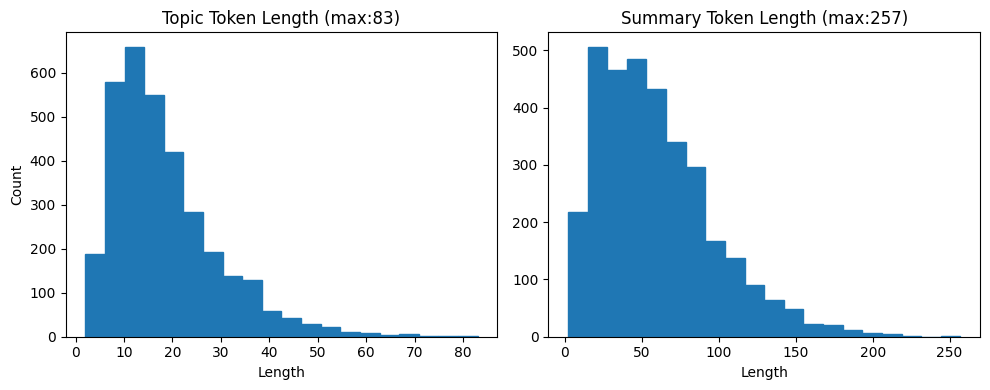

In [30]:
len_topic_token = train_concluions['topic'].apply(lambda x: len(x.split()))
len_summary_token = train_concluions['summary'].apply(lambda x: len(x.split()))

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(len_topic_token, bins = 20, color = 'C0', edgecolor = 'C0')
axes[0].set_title(f"Topic Token Length (max:{max(len_topic_token)})")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")

axes[1].hist(len_summary_token, bins = 20, color = 'C0', edgecolor = 'C0' )
axes[1].set_title(f"Summary Token Length (max:{max(len_summary_token)})")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

In [31]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch['topic'] , max_length = 100, truncation = True )

    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch['summary'], max_length = 260, truncation = True )

    return {
        'input_ids' : input_encodings['input_ids'],
        'attention_mask': input_encodings['attention_mask'],
        'labels': target_encodings['input_ids']
    }

train_concluions_pt = train_concluions.apply(convert_examples_to_features, axis=1)

In [33]:
train_pt, val_pt = train_test_split(train_concluions_pt, test_size=0.2, random_state=42)
train_pt.reset_index(drop=True, inplace=True)
val_pt.reset_index(drop=True, inplace=True)

In [42]:
seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

trainer_args = TrainingArguments(
    output_dir='concluions', num_train_epochs=1, warmup_steps=500,
    per_device_train_batch_size=1, per_device_eval_batch_size=1,
    weight_decay=0.01, logging_steps=10,
    evaluation_strategy='steps', eval_steps=500, save_steps=1e6,
    gradient_accumulation_steps=16
)
trainer = Trainer(model=model, args=trainer_args,
                  tokenizer=tokenizer, data_collator=seq2seq_data_collator,
                  train_dataset = train_concluions_pt,#train_dataset=train_pt,
                  )#eval_dataset=val_pt

In [39]:
trainer.train()

Step,Training Loss,Validation Loss


TrainOutput(global_step=207, training_loss=3.279490199066015, metrics={'train_runtime': 397.0979, 'train_samples_per_second': 8.361, 'train_steps_per_second': 0.521, 'total_flos': 170265853181952.0, 'train_loss': 3.279490199066015, 'epoch': 1.0})

In [40]:
score = calculate_metric_on_test_ds(test, rouge_metric, trainer.model, tokenizer, column_text = 'topic',column_summary="summary",batch_size = 8)
rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )

pd.DataFrame(rouge_dict, index = [f'facebook bart based'] )

100%|██████████| 83/83 [05:42<00:00,  4.12s/it]


,rouge1,rouge2,rougeL,rougeLsum
facebook bart based,0.023027,0.000311,0.022576,0.022589


In [41]:
"""
model.save_pretrained("model_for_concluions")
tokenizer.save_pretrained("tokenizer_for_concluions")
"""
trainer.model.push_to_hub("FTBartBasedModel4concluions")
trainer.tokenizer.push_to_hub("FTBartBasedModelTokenizer4concluions")

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}


model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/necover/FTBartBasedModelTokenizer4concluions/commit/38279b22f507c78c449979e58832e9dacfed9e64', commit_message='Upload tokenizer', commit_description='', oid='38279b22f507c78c449979e58832e9dacfed9e64', pr_url=None, pr_revision=None, pr_num=None)